In [1]:
# import libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import h3
from shapely.geometry import Polygon

In [4]:
# load data

sa = gpd.read_parquet('./data/study_area.parquet')
sa_buf = gpd.read_parquet('./data/study_area_buf.parquet')

<AxesSubplot:>

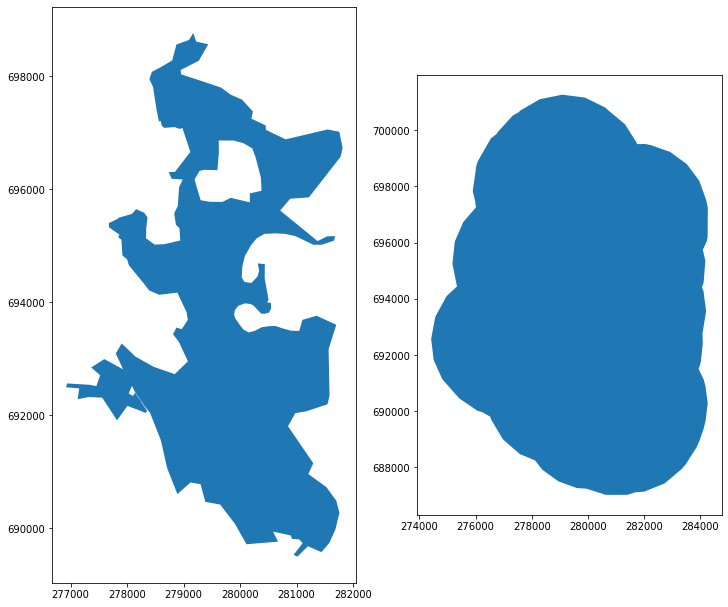

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,12))
sa.plot(ax=ax[0])
sa_buf.plot(ax=ax[1])

# Generate hexagonal tessellation
We will generate a hexagonal tessellation covering our buffered study area. We want to generate a buffer to account for accessibility in the borders of our study area. The H3 algorithm provides different cell areas resolutions. For our analysis, we will be using resollution 11, which will give us hexagons of approximately 25 metre-radius. Once we've generated our tessels, we will need to calculate the centroids of each hexagon, as we will be using those points as the origins and destinations for our simplified accessibility score.

In [6]:
local_crs = 27700

In [7]:
# generate tessellation for our study area
tess = h3.polyfill(sa_buf.to_crs(4326).geometry[0].__geo_interface__, 11, geo_json_conformant = True)

polygonise = lambda hex_id: Polygon(
                                h3.h3_to_geo_boundary(
                                    hex_id, geo_json=True)
                                    )

%time polys = gpd.GeoSeries(list(map(polygonise, tess)), \
                                      index=tess, \
                                      crs="EPSG:4326" \
                                     )

hexagons = gpd.GeoDataFrame({"geometry": polys,
                                 "hex_id": polys.index},
                                crs=polys.crs
                               )

# calculate the centroids of the tessells
centroids = hexagons.to_crs(local_crs).centroid

# set geometry
centroids = gpd.GeoDataFrame(geometry=gpd.GeoSeries(centroids))

# reset and rename index
centroids = centroids.reset_index().rename(columns={'index':'oriID'})

# save
centroids.to_parquet('./data/centroids.parquet')
hexagons.to_parquet('./data/hexagons.parquet')


CPU times: user 1.85 s, sys: 25.1 ms, total: 1.88 s
Wall time: 1.88 s


<AxesSubplot:>

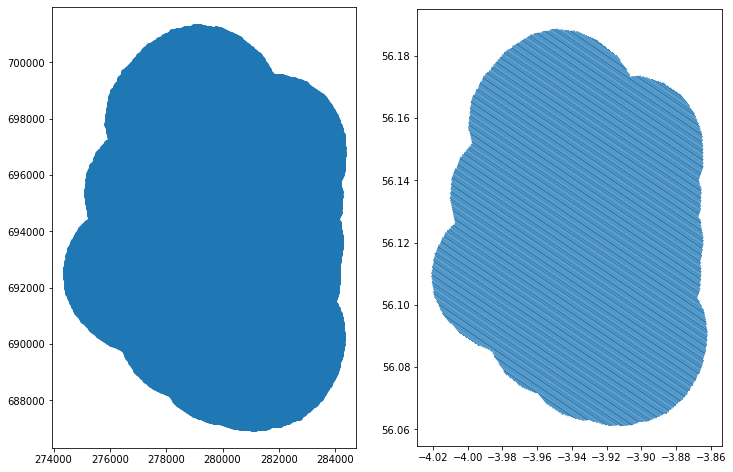

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,12))
centroids.plot(ax=ax[0])
hexagons.plot(ax=ax[1])